# **Aufbau eines Empfehlungssystems (Projekt 2)**

**Ziel des Projekts:**


*   Die Anzahl der relevanten Items aufzulisten, deren tatsächliche Bewertung 3,5 oder höher ist.
*   Die empfohlenen Items zu listen
*   Die Anzahl der empfohlenen und relevanten Items aufzulisten
*   den Prozentsatz der Empfehlungen zu berechnen, die für den Nutzer tatsächlich relevant sind
*   den Prozentsatz der relevanten Items berechnen, die in den Top-k-Items/Movies empfohlen wurden









In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from google.colab import files
import io

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
uploader = files.upload() 

Saving ratings.csv to ratings.csv


In [ ]:
df= pd.read_csv(io.BytesIO(uploader["ratings.csv"]))

In [ ]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
df.userId.nunique()

610

In [ ]:
df.movieId.nunique()

9724

In [ ]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [ ]:
df.shape

(100836, 4)

# **Training Dataset**

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
      #iniatilisation of Users, movies and ratings
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1], return the position 1
    def __getitem__(self, item):

        users = self.users[item] 
        movies = self.movies[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

# **Model**

In [ ]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        
        output = self.out(output)
        
        return output

In [ ]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)


In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

dataiter = iter(train_loader)
dataloader_data = dataiter.next() 
print(dataloader_data)

{'users': tensor([425, 143, 473, 176]), 'movies': tensor([3633,  509, 2890, 7116]), 'ratings': tensor([1, 3, 3, 3])}


In [ ]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [ ]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


# **Forward Path**

In [ ]:

print(dataloader_data['users']) # The first Data of User

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)

tensor([425, 143, 473, 176])
torch.Size([4])
tensor([3633,  509, 2890, 7116])
torch.Size([4])


In [ ]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[-0.3525,  0.0767, -0.5836,  0.9129, -0.1740,  2.3694,  1.1888,  0.4176,
          1.6498,  0.5498,  0.4852,  0.1662, -1.4934,  0.7971, -1.4829,  0.9159,
          0.2508,  0.5585, -1.2233, -0.3789,  0.1045,  0.1398,  0.9248,  1.1349,
          2.0591,  0.6061, -0.7491,  0.1202,  1.1150, -0.9957,  0.4881,  0.5859],
        [ 1.9151,  0.0635, -0.0380, -1.7780, -0.4308,  0.4391,  0.1854,  0.9889,
          1.2309, -1.0957, -0.0896,  3.2417,  2.8546,  0.3904, -0.4163, -0.4352,
         -1.3179, -0.2399, -1.2911,  0.0415, -0.0191, -1.8907,  0.7516,  0.1403,
          0.6400,  0.9459, -2.6258, -1.1579,  0.8535, -0.6203, -0.6656, -0.5578],
        [-1.2072,  2.1634, -2.1761, -1.7097, -0.2282, -0.0088, -0.9151, -0.1417,
         -0.1019,  1.4114, -0.5787,  0.5921,  1.7205, -0.4814, -0.0771, -0.2903,
         -1.1581, -0.5171, -0.6254,  0.5771, -0.7166,  2.6479,  0.6984, -0.0347,
         -0.0760,  0.6770,  0.0790,  0.2076,  0.7906,  1.6142, 

In [ ]:
#COncatenation of User_embeds and movie_embeds
output = torch.cat([user_embeds, movie_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[-0.3525,  0.0767, -0.5836,  0.9129, -0.1740,  2.3694,  1.1888,  0.4176,
          1.6498,  0.5498,  0.4852,  0.1662, -1.4934,  0.7971, -1.4829,  0.9159,
          0.2508,  0.5585, -1.2233, -0.3789,  0.1045,  0.1398,  0.9248,  1.1349,
          2.0591,  0.6061, -0.7491,  0.1202,  1.1150, -0.9957,  0.4881,  0.5859,
          0.3671,  0.1874,  0.2010, -1.0044,  2.1325, -0.1572, -0.5482, -0.9249,
         -1.2142,  0.1063,  0.4616,  0.7760, -1.5396,  0.4932,  0.5559,  0.4847,
         -1.1310,  1.0294, -1.1185, -0.3606,  0.6240, -0.4056, -0.3282, -0.3828,
         -0.6060,  0.5061,  2.1196,  0.6330, -0.8578,  1.1494,  0.0533,  0.5154],
        [ 1.9151,  0.0635, -0.0380, -1.7780, -0.4308,  0.4391,  0.1854,  0.9889,
          1.2309, -1.0957, -0.0896,  3.2417,  2.8546,  0.3904, -0.4163, -0.4352,
         -1.3179, -0.2399, -1.2911,  0.0415, -0.0191, -1.8907,  0.7516,  0.1403,
          0.6400,  0.9459, -2.6258, -1.1579,  0.8535, -0.6203, -0.6656, 

In [ ]:
with torch.no_grad():
    model_output = model(dataloader_data['users'], 
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[ 0.0619],
        [-0.1330],
        [-0.1836],
        [ 0.1028]]), size: torch.Size([4, 1])


In [ ]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1)) # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([1, 3, 3, 3])
tensor([[1],
        [3],
        [3],
        [3]])
tensor([[ 0.0619],
        [-0.1330],
        [-0.1836],
        [ 0.1028]])
tensor(10)
tensor(-10.1519)


In [ ]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"], 
                       train_data["movies"]
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 0.4704935305759311
epoch 0 loss at step: 10000 is 0.16740894335331397
epoch 0 loss at step: 15000 is 0.10215041832849384
epoch 0 loss at step: 20000 is 0.08022771014889003
epoch 0 loss at step: 25000 is 0.07264332084814086
epoch 0 loss at step: 30000 is 0.0708156846037833
epoch 0 loss at step: 35000 is 0.06525410727402195
epoch 0 loss at step: 40000 is 0.06413209105124697
epoch 0 loss at step: 45000 is 0.061105795743374616
epoch 0 loss at step: 50000 is 0.06219643149115145
epoch 0 loss at step: 55000 is 0.058877538918470966
epoch 0 loss at step: 60000 is 0.06152528892224655
epoch 0 loss at step: 65000 is 0.05686107304478064
epoch 0 loss at step: 70000 is 0.054956770219327884
epoch 0 loss at step: 75000 is 0.05842199429543689
epoch 0 loss at step: 80000 is 0.05954778735637665
epoch 0 loss at step: 85000 is 0.05593160749003291
epoch 0 loss at step: 90000 is 0.05683693801253103


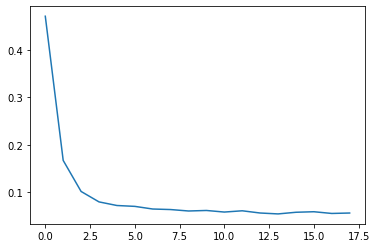

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

# **Evaluation with RMSE (Root mean square error)**


In [ ]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'], 
                       batched_data["movies"])
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [2.8486],
        [3.3350],
        [2.9409]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[4.1340],
        [3.9009],
        [2.7896],
        [2.6276]]), target_rating: tensor([4, 5, 2, 5])
model_output: tensor([[2.8591],
        [4.1511],
        [3.9064],
        [4.0593]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.1719],
        [3.3514],
        [3.0365],
        [3.0705]]), target_rating: tensor([2, 3, 3, 2])
model_output: tensor([[2.8785],
        [2.7033],
        [3.5804],
        [2.2675]]), target_rating: tensor([5, 4, 4, 3])
model_output: tensor([[3.0653],
        [3.0902],
        [3.3115],
        [3.9422]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.3479],
        [4.1334],
        [3.5842],
        [2.9619]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[4.4524],
        [2.8950],
        [3.0971],
        [4.0923]])

# **Evaluation with Recall@K**

**Precision** at k is the proportion of recommended items in the top-k set that are relevant.
**Recall at k** is the proportion of relevant items found in the top-k recommendations




In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']
        
        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))      

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
607, 30, 2.797107219696045, 3
605, 2371, 3.8109452724456787, 4
554, 1468, 3.836115598678589, 4
482, 5078, 3.1865670680999756, 4
132, 412, 3.099616527557373, 3
481, 509, 3.6291427612304688, 4
231, 2021, 2.8227109909057617, 3
109, 977, 3.7499682903289795, 4
566, 6405, 2.29148268699646, 3
72, 6203, 3.445866823196411, 4
67, 4474, 2.9929771423339844, 3
516, 9352, 1.9254586696624756, 1
413, 6434, 3.229870557785034, 2
579, 486, 3.670227289199829, 2
609, 5928, 3.099820852279663, 3
176, 1066, 3.605574607849121, 3
413, 3218, 3.4383089542388916, 3
110, 6061, 2.9121267795562744, 3
560, 6329, 3.34749698638916, 3
609, 7570, 3.829995632171631, 3
62, 334, 3.451279640197754, 2
65, 2296, 3.6720290184020996, 3
500, 431, 2.9961092472076416, 3
23, 7039, 3.0848493576049805, 3
381, 6911, 3.266946792602539, 5
135, 159, 3.648660182952881, 5
176, 1601, 3.39467453956604, 2
413, 6612, 3.073101043701172, 3
32, 1938, 4.4561767578125, 5
30

In [ ]:
# The number of relevant items/Movies are the Movies with actual rating greater or equal to 3.5.
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=100
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. / We sort the rest of the items/Movies by descending prediction rating
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        #  get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 139,  n_rel 19, n_rec_k 27, n_rel_and_rec_k 11
uid 598,  n_rel 22, n_rec_k 0, n_rel_and_rec_k 0
uid 605,  n_rel 65, n_rec_k 75, n_rel_and_rec_k 40
uid 317,  n_rel 38, n_rec_k 34, n_rel_and_rec_k 19
uid 572,  n_rel 24, n_rec_k 32, n_rel_and_rec_k 24
uid 293,  n_rel 9, n_rec_k 2, n_rel_and_rec_k 1
uid 253,  n_rel 10, n_rec_k 9, n_rel_and_rec_k 9
uid 554,  n_rel 26, n_rec_k 54, n_rel_and_rec_k 23
uid 155,  n_rel 21, n_rec_k 22, n_rel_and_rec_k 14
uid 607,  n_rel 27, n_rec_k 6, n_rel_and_rec_k 3
uid 473,  n_rel 74, n_rec_k 14, n_rel_and_rec_k 13
uid 488,  n_rel 14, n_rec_k 0, n_rel_and_rec_k 0
uid 72,  n_rel 14, n_rec_k 17, n_rel_and_rec_k 11
uid 129,  n_rel 2, n_rec_k 3, n_rel_and_rec_k 2
uid 566,  n_rel 2, n_rec_k 0, n_rel_and_rec_k 0
uid 81,  n_rel 6, n_rec_k 3, n_rel_and_rec_k 2
uid 468,  n_rel 29, n_rec_k 37, n_rel_and_rec_k 27
uid 322,  n_rel 2, n_rec_k 2, n_rel_and_rec_k 0
uid 198,  n_rel 8, n_rec_k 8, n_rel_and_rec_k 5
uid 44,  n_rel 20, n_rec_k 31, n_rel_and_rec_k 18
uid 95,  

In [ ]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 100: 0.570052575963988
recall @ 100 : 0.573863360248199



*   **only 57.00% of my recommendations are actually relevant to the user**
*   **57.38% percent of the relevant Movies were recommended in the top-100 Movies**